/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: The following kwargs were not used by contour: 'add_labels'


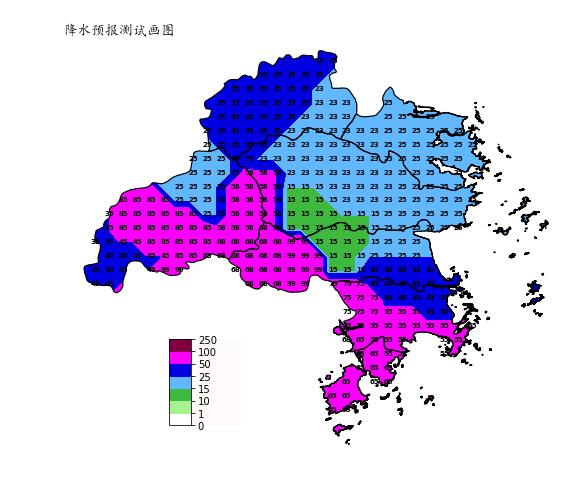

In [5]:
# coding=UTF-8
import gevent
from math import isnan
import numpy as np
#import modin.pandas as pd 
import pandas as pd
import time
import netCDF4 
# import h5netcdf.legacyapi as netCDF4
import h5py

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shapefile
import matplotlib as mpl
import xarray as xr
from matplotlib.font_manager import FontProperties
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
import geopandas as gpd
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import math
from scipy.interpolate import griddata
from math import ceil, floor
from rasterio import features
from affine import Affine
import os
from datetime import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib.font_manager import FontProperties  # 步骤一

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

basicfile = '/home/liyuan3970/Data/My_Git/web_met/'

class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)

class canvas_plot:
    def __init__(self, plot_self_data,plot_title,plot_bar):
        self.plot_self_data = plot_self_data
        self.plot_title = plot_title
        self.plot_bar = plot_bar
        self.data = self.read_data()

    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da
    def basemask(self,cs, ax, map, shpfile):
        sf = shapefile.Reader(shpfile)
        vertices = []
        codes = []
        for shape_rec in sf.shapeRecords():
            if shape_rec.record[0] >= 0:  
                pts = shape_rec.shape.points
                prt = list(shape_rec.shape.parts) + [len(pts)]
                for i in range(len(prt) - 1):
                    for j in range(prt[i], prt[i+1]):
                        vertices.append(map(pts[j][0], pts[j][1]))
                    codes += [Path.MOVETO]
                    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                    codes += [Path.CLOSEPOLY]
                clip = Path(vertices, codes)
                clip = PathPatch(clip, transform = ax.transData)    
        for contour in cs.collections:
            contour.set_clip_path(clip)    
    def makedegreelabel(self,degreelist):
        labels=[str(x)+u'°E' for x in degreelist]
        return labels
    def colormap(self,levels):
        '''色标的自定义'''
        plt.rcParams['axes.facecolor']='snow'
        colorslist = ['#FFFFFF','#A6F28f','#3DBA3D',"#61B8FF","#0000E1","#FA00FA","#800040"]# 降水
        levels = [0,1,10,15,25,50,100,250]
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=7)
        cmap_nonlin = nlcmap(cmaps, levels)
        #  
        #levels = [10,20,30,40,50,60,70,80] 
        return cmap_nonlin ,levels
    def read_data(self):
        data = self.plot_self_data
        a = []
        b = []
        z = []
        for i in range(len(data['station'])):
            if data['station'][i][2]!=-9999.0:
                a.append(data['station'][i][0])
                b.append(data['station'][i][1])
                z.append(data['station'][i][2])
        lat = np.array(b)
        lon = np.array(a)
        Zi = np.array(z)
        data_max = max(Zi)
        data_min = min(Zi)
        np.set_printoptions(precision = 2)
        x = np.arange(120.0,122.0,0.05)
        y = np.arange(27.8,29.5,0.05)
        nx0 =len(x)
        ny0 =len(y)
        X, Y = np.meshgrid(x, y)#100*100
        P = np.array([X.flatten(), Y.flatten() ]).transpose()    
        Pi =  np.array([lon, lat ]).transpose()
        Z_linear = griddata(Pi, Zi, P, method = "nearest").reshape([ny0,nx0])
        data_xr = xr.DataArray(Z_linear, coords=[ y,x], dims=["lat", "lon"])
        return data_xr    
    def village_data(self):
        data_xr = self.data
        shp_path = "shpfile/"
        shp_data = gpd.read_file("shpfile/xiangzhen.shp", encoding='utf8')
        village_list = shp_data['NAME'].values
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"xiangzhen.shp", "country")
        data_dir = {}
        for i in range(len(village_list)):
            awash_da = shp_da.where(shp_da.country==i, other=np.nan)
            name = village_list[i]
            data_dir[name]  = awash_da.mean().values.tolist()
        d_result=sorted(data_dir.items(),key=lambda x:x[1],reverse=False)
        return d_result    
    def shp_average(self):
        data_xr = self.read_data()
        shp_path = "shpfile/"
        shp_data = gpd.read_file("shpfile/taizhou.shp", encoding='utf8')
        county_list = shp_data['NAME_3'].values
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "country")
        data_list = []
        for i in range(len(county_list)):
            awash_da = shp_da.where(shp_da.country==i, other=np.nan)
            data_list.append(awash_da.mean())
        return data_list
    def plot_img(self):
        '''绘制自定义图'''
        data_xr = self.data
        # ##########色标和大小#############################
        cmaps ,levels = self.colormap(self.plot_bar)
        fig = plt.figure(figsize=[10,10]) 
        ax = fig.add_subplot(111)
        # shp_path = "static/data/shpfile/"
        shp_path = "shpfile/"
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "country")
        awash_da = shp_da.where(shp_da.country<7, other=np.nan)
        lat = data_xr.lat
        lon = data_xr.lon
        m = Basemap(llcrnrlon=120.0,
            llcrnrlat=27.8,
            urcrnrlon=122,
            urcrnrlat=29.5,
            resolution = None, 
            projection = 'cyl')
        lons, lats = np.meshgrid(lon, lat)
        cs =m.contourf(lons,lats,data_xr,ax=ax, cmap=cmaps,levels =levels,add_labels=True)
        ##########标题#############################
        font = FontProperties(fname="simkai.ttf", size=14)
        # 为matplotlib中文无法显示设置字体
        #plt.rcParams['font.sans-serif'] = 'SimHei' # 黑体
        label  = self.plot_title
        plt.text(120.2,29.4, label,fontsize=15, fontproperties=font)
        ##########标题#############################
        m.readshapefile(shp_path+'taizhou','taizhou',color='k',linewidth=1.2)
        plt.axis('off') 
#         parallels = np.arange(27.8,29.5,0.2)
#         m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
#         meridians = np.arange(120.0,122.0,0.2)
#         m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.80+j*0.05,2)
                x0 = round(120.00+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")            
        # 在图上绘制色标
        rect1 = [0.35, 0.25, 0.03, 0.12]         
        ax2 = plt.axes(rect1,frameon='False')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        m.colorbar(cs, location='right', size='30%', pad="-100%",ax = ax2)
        self.basemask(cs, ax, m, shp_path+'taizhou') 
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd


plot_self_data = {
        "station_list": ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'],
        "station": [
            [120.5, 28.5, 99],
            [120.92, 28.78, 58.3],
            [120.47, 28.55, 45],
            [120.91, 29.11, 35],
            [121.46, 28.94, 25],
            [121.05, 28.77, 15],
            [121.41, 28.64, 25],
            [120.21, 28.66, 35],
            [121.41, 28.47, 45],
            [121.40, 28.34, 55],
            [121.15, 27.94, 65],
            [121.21, 28.41, 75],
            [120.54, 28.70, 85],
            [121.20, 28.68, 15],
            [120.66, 28.89, 25],
            [121.04, 29.00, 23],
            [121.25, 28.90, 23],
            [121.21, 28.20, 65],
            [121.15, 28.25, 68],
            [120.95, 28.60, 68],
            [121.00, 28.60, 99]

        ]
    }
    
plot_title,plot_bar  = "降水预报测试画图" ,[0,1,2,3,4,5,6,7]  
worker = canvas_plot(plot_self_data,plot_title,plot_bar)
img = worker.plot_img()

In [ ]:
[<xarray.DataArray ()>
 array(52.95),
 <xarray.DataArray ()>
 array(25.91),
 <xarray.DataArray ()>
 array(24.6),
 <xarray.DataArray ()>
 array(31.16),
 <xarray.DataArray ()>
 array(58.05),
 <xarray.DataArray ()>
 array(57.7),
 <xarray.DataArray ()>
 array(65.)]

array(['Huangyan', 'Linhai', 'Sanmen', 'Tiantai', 'Wenling', 'Xianju',
       'Yuhuan'], dtype=object)

In [18]:
# 查询当前系统所有字体
from matplotlib.font_manager import FontManager
import subprocess
mpl_fonts = set(f.name for f in FontManager().ttflist)
print('all font list get from matplotlib.font_manager:')
for f in sorted(mpl_fonts):
    print('\t' + f)

all font list get from matplotlib.font_manager:
	Arial
	Bahnschrift
	Bitstream Vera Sans
	Bitstream Vera Sans Mono
	Bitstream Vera Serif
	Calibri
	Cambria
	Candara
	Comic Sans MS
	Consolas
	Constantia
	Corbel
	Courier New
	DejaVu Math TeX Gyre
	DejaVu Sans
	DejaVu Sans Display
	DejaVu Sans Mono
	DejaVu Serif
	DejaVu Serif Display
	DengXian
	Ebrima
	FangSong
	Franklin Gothic Medium
	Gabriola
	Gadugi
	Georgia
	HoloLens MDL2 Assets
	Impact
	Ink Free
	Javanese Text
	KaiTi
	Leelawadee UI
	Liberation Mono
	Liberation Sans
	Liberation Sans Narrow
	Liberation Serif
	Lucida Console
	Lucida Sans Unicode
	MS Gothic
	MV Boli
	Malgun Gothic
	Marlett
	Microsoft Himalaya
	Microsoft JhengHei
	Microsoft New Tai Lue
	Microsoft PhagsPa
	Microsoft Sans Serif
	Microsoft Tai Le
	Microsoft YaHei
	Microsoft Yi Baiti
	MingLiU-ExtB
	Mongolian Baiti
	Myanmar Text
	Nirmala UI
	Palatino Linotype
	STIXGeneral
	STIXNonUnicode
	STIXSizeFiveSym
	STIXSizeFourSym
	STIXSizeOneSym
	STIXSizeThreeSym
	STIXSizeTwoSym
	Segoe 

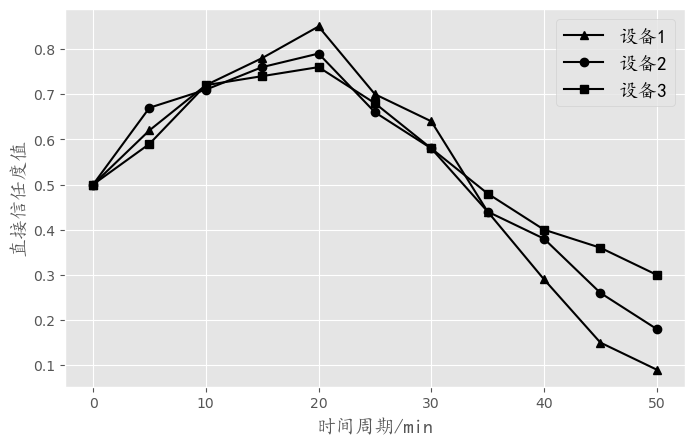

In [33]:
# -*- coding: UTF-8 -*-
"""
@Author  ：叶庭云
@公众号  ：修炼Python
@CSDN    ：https://yetingyun.blog.csdn.net/
三折线  黑白灰风格  标签label 标记点形状
"""
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  # 步骤一
# 生成x轴数据  列表推导式
x_data = [i for i in range(0, 55, 5)]

# 构造y轴数据
y_data1 = [0.5, 0.62, 0.72, 0.78, 0.85, 0.7, 0.64, 0.44, 0.29, 0.15, 0.09]
y_data2 = [0.5, 0.67, 0.71, 0.76, 0.79, 0.66, 0.58, 0.44, 0.38, 0.26, 0.18]
y_data3 = [0.5, 0.59, 0.72, 0.74, 0.76, 0.68, 0.58, 0.48, 0.4, 0.36, 0.3]

# 设置图形显示风格
plt.style.use('ggplot')
#font = FontProperties(fname="simkai.ttf", size=14)  # 步骤二
# 设置figure大小  像素
plt.figure(figsize=(8, 5), dpi=100)

# 绘制三条折线  点的形状 颜色  标签：用于图例显示
plt.plot(x_data, y_data1, marker='^', color="k", label="设备1")
plt.plot(x_data, y_data2, marker="o", color="k", label="设备2")
plt.plot(x_data, y_data3, marker="s", color="k", label="设备3")

# x y 轴标签   字体大小
plt.xlabel("时间周期/min", fontsize=13, fontproperties=font)
plt.ylabel("直接信任度值", fontsize=13, fontproperties=font)
# 显示图例
plt.legend(prop=font)

# 保存图片  展示show
plt.savefig("折线图01.png", dpi=200)
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


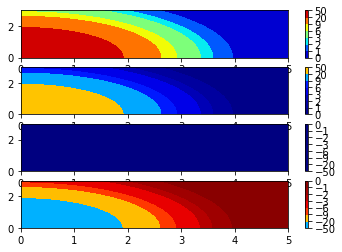

In [4]:
from pylab import *
from numpy import *
from matplotlib.colors import LinearSegmentedColormap

class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)

if __name__ == '__main__':

    y, x = mgrid[0.0:3.0:100j, 0.0:5.0:100j]
    H = 50.0 * exp( -(x**2 + y**2) / 4.0 )
    levels = [0, 1, 2, 3, 6, 9, 20, 50]

    H1 = -50.0 * exp( -(x**2 + y**2) / 4.0 )
    levels1 = [-50, -20, -9, -6, -3, -2, -1, 0]

    cmap_lin = cm.jet
    cmap_nonlin = nlcmap(cmap_lin, levels)
    cmap_lin1 = cm.jet
    cmap_nonlin1 = nlcmap(cmap_lin1, levels1)

    subplot(4,1,1)
    contourf(x, y, H, levels, cmap=cmap_nonlin)
    colorbar()
    subplot(4,1,2)
    contourf(x, y, H, levels, cmap=cmap_lin)
    colorbar()
    subplot(4,1,3)
    contourf(x, y, H1, levels1, cmap=cmap_nonlin1)
    colorbar()
    subplot(4,1,4)
    contourf(x, y, H1, levels1, cmap=cmap_lin1)
    colorbar()

    plt.show()  

## Canvas 绘图的核心代码

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: The following kwargs were not used by contour: 'add_labels'


CPU times: user 3.16 s, sys: 1.32 s, total: 4.48 s
Wall time: 43.5 s


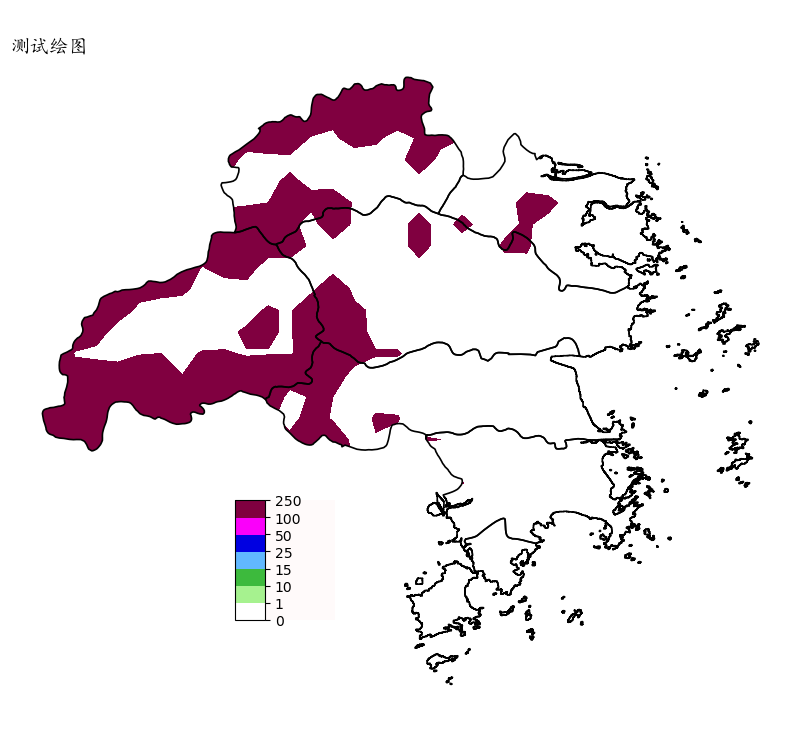

In [1]:
%%time
# coding=UTF-8
import gevent
from math import isnan
import numpy as np
#import modin.pandas as pd 
import pandas as pd
import time
import netCDF4 
# import h5netcdf.legacyapi as netCDF4
import h5py

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shapefile
import matplotlib as mpl
import xarray as xr
from matplotlib.font_manager import FontProperties
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
import geopandas as gpd
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import math
from scipy.interpolate import griddata
from math import ceil, floor
from rasterio import features
from affine import Affine
import os
from datetime import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib.font_manager import FontProperties  # 步骤一

import pymysql
import pymssql
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

basicfile = '/home/liyuan3970/Data/My_Git/web_met/'

class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = np.linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)
### 核心的绘图代码
class canvas_plot:
    def __init__(self, plot_start_time,plot_end_time,plot_type):
        self.start = plot_start_time
        self.end = plot_end_time
        self.plot_type = plot_type
        self.conn = pymysql.connect(host="127.0.0.1",port=3306,user="root",passwd="051219",db="ZJSZDZDB")
    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da
    def basemask(self,cs, ax, map, shpfile):
        sf = shapefile.Reader(shpfile)
        vertices = []
        codes = []
        for shape_rec in sf.shapeRecords():
            if shape_rec.record[0] >= 0:  
                pts = shape_rec.shape.points
                prt = list(shape_rec.shape.parts) + [len(pts)]
                for i in range(len(prt) - 1):
                    for j in range(prt[i], prt[i+1]):
                        vertices.append(map(pts[j][0], pts[j][1]))
                    codes += [Path.MOVETO]
                    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                    codes += [Path.CLOSEPOLY]
                clip = Path(vertices, codes)
                clip = PathPatch(clip, transform = ax.transData)    
        for contour in cs.collections:
            contour.set_clip_path(clip)    
    # 内部函数
    def get_sql_data(self):      
        '''sql 获取数据'''
        table = 'Tab_AM_M'
        sqlview = """"""
        sqlrain = """"""
        sqlwind = """"""
        sqltmax = """"""
        sqltmin = """select ta.IIiii,station.lat,station.lon,min(T) as value
        from {table} as ta inner join TAB_StationInfo as station on ta.IIiii=station.IIiii  
        where (tTime between '{start}' and '{end}' and station.lon>119 and station.lon<122 and station.lat>27.5 and station.lat<29.5 ) group by station.IIiii,station.lat,station.lon """
        rsql = sqltmin.format(start=self.start,end=self.end,table=table)
        data = pd.read_sql(rsql , con=self.conn)
        drop = data[data['value']!=-9999]
        lat = np.array(drop['lat'].to_list())
        lon = np.array(drop['lon'].to_list())
        Zi = np.array(drop['value'].to_list())
        data_max = max(Zi)
        data_min = min(Zi)
        np.set_printoptions(precision = 2)
        x = np.arange(120.0,122.0,0.05)
        y = np.arange(27.8,29.5,0.05)
        nx0 =len(x)
        ny0 =len(y)
        X, Y = np.meshgrid(x, y)#100*100
        P = np.array([X.flatten(), Y.flatten() ]).transpose()    
        Pi =  np.array([lon, lat ]).transpose()
        Z_linear = griddata(Pi, Zi, P, method = "nearest").reshape([ny0,nx0])
        data_xr = xr.DataArray(Z_linear, coords=[ y,x], dims=["lat", "lon"])
        return data_xr
    def colormap(self):
        '''色标的自定义'''
        plt.rcParams['axes.facecolor']='snow'
        colorslist = ['#FFFFFF','#A6F28f','#3DBA3D',"#61B8FF","#0000E1","#FA00FA","#800040"]# 降水
        levels = [0,1,10,15,25,50,100,250]
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=7)
        cmap_nonlin = nlcmap(cmaps, levels)
        #levels = [10,20,30,40,50,60,70,80] 
        return cmap_nonlin ,levels
    def plot_mark(self):
        pass
    def plot_label(self):
        pass
    def plot_img(self):
        data_xr = self.get_sql_data()
        # ##########色标和大小#############################
        cmaps ,levels = self.colormap()
        fig = plt.figure(figsize=[10,10]) 
        ax = fig.add_subplot(111)
        shp_path = "shpfile/"
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "country")
        awash_da = shp_da.where(shp_da.country<7, other=np.nan)
        lat = data_xr.lat
        lon = data_xr.lon
        m = Basemap(llcrnrlon=120.2,
            llcrnrlat=27.8,
            urcrnrlon=122,
            urcrnrlat=29.5,
            resolution = None, 
            projection = 'cyl')
        lons, lats = np.meshgrid(lon, lat)
        cs =m.contourf(lons,lats,data_xr,ax=ax, cmap=cmaps,levels =levels,add_labels=True)
        ##########标题#############################
        font = FontProperties(fname="simkai.ttf", size=14)
        # 为matplotlib中文无法显示设置字体
        #plt.rcParams['font.sans-serif'] = 'SimHei' # 黑体
        label  = "测试绘图"
        plt.text(120.2,29.4, label,fontsize=15, fontproperties=font)
        ##########标题#############################
        m.readshapefile(shp_path+'taizhou','taizhou',color='k',linewidth=1.2)
        plt.axis('off')
        # 在图上绘制色标
        rect1 = [0.35, 0.25, 0.03, 0.12]         
        ax2 = plt.axes(rect1,frameon='False')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        m.colorbar(cs, location='right', size='30%', pad="-100%",ax = ax2)
        self.basemask(cs, ax, m, shp_path+'taizhou') 
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd
        
        









start = '2019-08-08 06:00:00'  
end ='2019-08-08 09:00:00'
plot_type = 'tmax'
worker = canvas_plot(start,end,plot_type)
img = worker.plot_img()
# temp = worker.get_sql_data()





In [ ]:
worker.plot_img()

In [7]:
temp

<xarray.DataArray (lat: 34, lon: 40)>
array([[237, 246, 257, ..., 274, 274, 274],
       [231, 242, 242, ..., 274, 274, 274],
       [234, 224, 242, ..., 274, 274, 277],
       ...,
       [282, 278, 281, ..., 279, 279, 284],
       [262, 263, 270, ..., 285, 284, 285],
       [263, 263, 258, ..., 286, 284, 285]])
Coordinates:
  * lat      (lat) float64 27.8 27.85 27.9 27.95 28.0 ... 29.3 29.35 29.4 29.45
  * lon      (lon) float64 120.0 120.0 120.1 120.1 ... 121.8 121.8 121.9 121.9